In [3]:
import numpy as np
import matplotlib.pyplot as plt

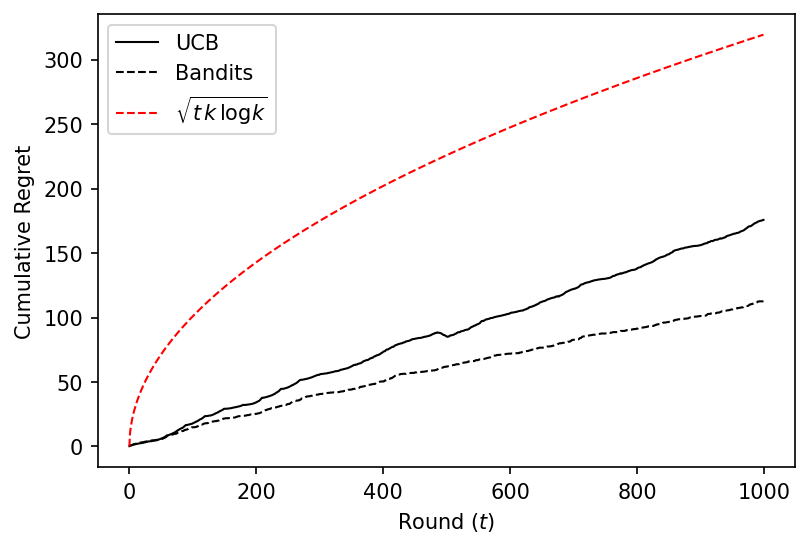

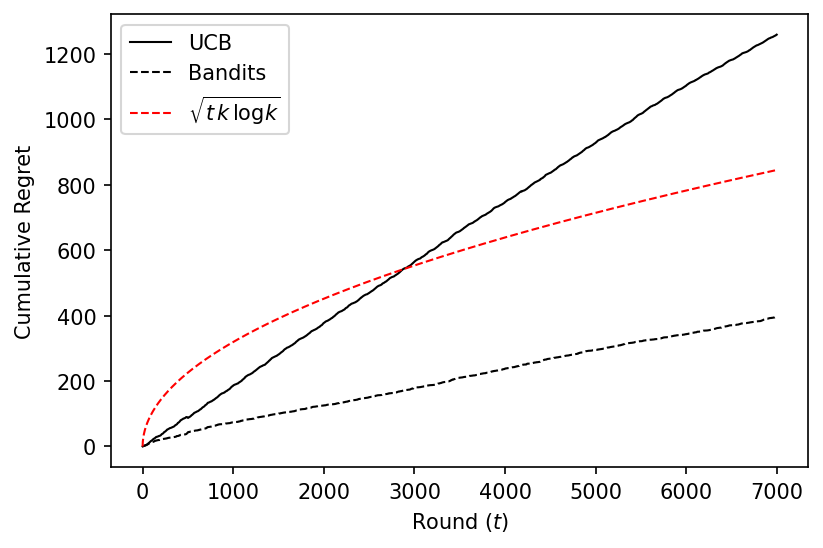

In [10]:
def multiplicative_weights_experts(data,k,T,eta):
    w = np.ones((k,))       # Weights for each expert, w_i^t
    
    loss = np.zeros((k,T))  # Loss of each expert at time t, l_i^t
    p = np.ones((k,))/k     # Probability distribution for each expert

    L_exp = np.zeros((T,))  # Expected loss at time t
    L = np.zeros((k,T))     # Total losses of each expert up to time t

    L_act = np.zeros((T,))  # Actual loss at time t

    for t in range(T):
        p = w/np.sum(w) # Compute probability distributions
        I = np.random.choice(range(k),p=p).astype(int) # Choose expert I_t, from p
        
        data_min = np.min(data[:,t])    # Find minimum at current time
        
        loss[:,t] = data[:,t] - data_min    # Compute current round losses

        w = (1-eta)**loss[:,t] * w      # Adjust weights

        L_exp[t] = np.sum(p*loss[:,t])
        L[:,t] = np.sum(loss[:,0:t],axis=1)

        L_act[t] = loss[I,t]

    L_alg = np.cumsum(L_exp)    # Total expected loss at time t
    L_opt = np.min(L,axis=0)    # Minimum loss w.r.t. i, at time t
    
    regret = L_alg - L_opt      # External regret
    return regret


def multiplicative_weights_bandits(data,k,T,eta,eps):
    w = np.ones((k,))       # Weights for each expert at current time, w_i^t

    p = np.ones((k,))/k     # Probability distribution for each expert
    loss = np.zeros((k,T))  # Loss of each expert at time t, l_i^t

    L = np.zeros((T,))

    for t in range(T):
        p = w/np.sum(w)
        q = (1-eps)*p + eps/k
        I = np.random.choice(range(k),p=q).astype(int)

        data_min = np.min(data[:,t])

        loss[:,t] = np.zeros((k,))              # Set losses to 0 forall i != I
        loss[I,t] = (data[I,t] - data_min)/q[I] # Compute loss for I and scale

        w = (1-eta)**loss[:,t]*w    # Adjust weights

        L[t] = data[I,t] - data_min

    return np.cumsum(L)

def upperConfidenceBound(data,k,T):
    Q = np.zeros((k,))
    mu = np.zeros((k,))

    ucb = np.ones((k,))*np.Inf

    loss = np.zeros((k,T))
    L = np.zeros((k,T))
    L_exp = np.zeros((T,))
    L_alg = np.zeros((k,T))

    for t in range(T):
        I = np.argmax(ucb)

        loss[:,t] = data[:,t] - np.min(data)

        Q[I] += 1
        mu[I] = np.sum(1-loss[I,:])/Q[I]
        ucb[I] = mu[I] + np.sqrt(np.log(T)/Q[I])

        L_exp[t] = loss[I,t]
        L[:,t] = np.sum(loss[:,0:t],axis=1)

    L_alg = np.cumsum(L_exp)
    L_opt = np.min(L,axis=0)
    
    regret = L_alg - L_opt
    return regret


def plot_MW(data,T,save=False):
    k = data.shape[0]
    # eta = np.sqrt(np.log(k)/T)
    eta = np.power(k*np.log(k)/T,1/3)

    regret_experts = multiplicative_weights_experts(data,k,T,eta)

    eps = eta
    regret_bandits = multiplicative_weights_bandits(data,k,T,eta,eps)

    regret_ucb = upperConfidenceBound(data,k,T)

    time = np.arange(T)
    plt.figure(dpi=150)
    plt.plot(regret_experts,'k',linewidth=1,label="Experts")
    plt.plot(regret_bandits,'k--',linewidth=1,label="Bandits")
    plt.plot(time,2*np.sqrt(time*np.log(k)),'r',linewidth=1,label="$2 \sqrt{t \, \log k}$")
    plt.plot(time,np.sqrt(time*k*np.log(k)),'r--',linewidth=1,label="$\sqrt{t \, k \, \log k}$")
    plt.xlabel('Round $(t)$')
    plt.ylabel('Cumulative Regret')
    plt.legend()
    if save:
        plt.savefig(f'./Report/Images/mw_compare_T{T}.png',dpi=300,bbox_inches='tight')
    plt.show()


def plot_UCB(data,T,save=False):
    k = data.shape[0]
    # eta = np.sqrt(np.log(k)/T)
    eta = np.power(k*np.log(k)/T,1/3)
    eps = eta

    regret_bandits = multiplicative_weights_bandits(data,k,T,eta,eps)

    regret_ucb = upperConfidenceBound(data,k,T)

    time = np.arange(T)
    plt.figure(dpi=150)
    plt.plot(regret_ucb,'k',linewidth=1,label="UCB")
    plt.plot(regret_bandits,'k--',linewidth=1,label="Bandits")
    plt.plot(time,np.sqrt(time*k*np.log(k)),'r--',linewidth=1,label="$\sqrt{t \, k \, \log k}$")
    plt.plot(time,,'r--',linewidth=1,label="$\sqrt{t \, k \, \log k}$")
    plt.xlabel('Round $(t)$')
    plt.ylabel('Cumulative Regret')
    plt.legend()
    if save:
        plt.savefig(f'./Report/Images/mw_compare_T{T}.png',dpi=300,bbox_inches='tight')
    plt.show()

# Read dataset
file = open("Milano_timeseries.csv")
data = np.loadtxt(file,delimiter=',',dtype=float)

# Part I
# plot_MW(data,1000,False)
# plot_MW(data,7000,False)

# Part II
plot_UCB(data,1000,False)
plot_UCB(data,7000,False)